In [1]:
# Study: Natural Language Processing with Deep Learning
# Dataset: Dead By Daylight Steam Reviews
# Author: Willian Oliveira and Julierme Silva
# Start: 10/04/2023
# Study Motivation: Train a machine to classify products based on user reviews
# Notebook Motivation: The purpose of this notebook is to train a Support Vector Machine model to classify the reviews using Bag of Words.
# Study Status: In Progress


In [2]:
# Importing the libraries and setting up the environment

import os
import random
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.svm import SVC
from gensim.models import Word2Vec
from sklearn.pipeline import Pipeline
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.model_selection import cross_validate
from sklearn.metrics import (
    precision_score,
    recall_score,
    f1_score,
    roc_auc_score,
    make_scorer,
    confusion_matrix,
    ConfusionMatrixDisplay,
)
from imblearn.under_sampling import RandomUnderSampler
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay


SEED = 0


def set_seeds(seed=SEED):
    os.environ["PYTHONHASHSEED"] = str(seed)
    random.seed(seed)
    np.random.seed(seed)


set_seeds()  # Setting seed for reproducible code

In [3]:
# Importing the dataset

X_train = np.load("data\processed\dbd_proc_train.npz",
                  allow_pickle=True)["X_train"]
y_train = np.load("data\processed\dbd_proc_train.npz",
                  allow_pickle=True)["y_train"]
X_val = np.load("data\processed\dbd_proc_val.npz", allow_pickle=True)["X_val"]
y_val = np.load("data\processed\dbd_proc_val.npz", allow_pickle=True)["y_val"]
X_test = np.load("data\processed\dbd_proc_test.npz",
                 allow_pickle=True)["X_test"]
y_test = np.load("data\processed\dbd_proc_test.npz",
                 allow_pickle=True)["y_test"]


In [4]:
# Verifying the shape of the dataset

print("X_train shape: ", X_train.shape, "y_train shape: ", y_train.shape)
print("X_val shape: ", X_val.shape, "y_val shape: ", y_val.shape)
print("X_test shape: ", X_test.shape, "y_test shape: ", y_test.shape)


X_train shape:  (138588,) y_train shape:  (138588,)
X_val shape:  (17324,) y_val shape:  (17324,)
X_test shape:  (17324,) y_test shape:  (17324,)


In [5]:
# Concatenate train and validation sets since we are using Cross Validation

X_train = np.concatenate((X_train, X_val))
y_train = np.concatenate((y_train, y_val))

In [6]:
# Verifying the first 5 reviews and their labels

for i in range(5):
    print("Review: ", X_train[i])
    print("Label:  ", y_train[i], "\n")


Review:  played many game life none left feeling horrible large chunk playerbase play torment others way transcending game anything match sole purpose making miserable throw insult mock match abide rule play nice likely loose flame anyway survivor killer player stuck gameplay loop inherently unfun side higher level play optimal also boring frustrating everyone many perk greatly unbalanced dominating game killer feel absolutely powerless helpless survivor dance front mock survivor get targetted frustrated killer tunneled game early vicious cycle hatred u v mentality frustration many people call toxic wear badge honour acting accordingly devs history acknowledging state community leaving feature exploit game specifically bully player nothing actual gameplay even told people issue play another game one past stream therefore unlikely ever get better issue extends accessibility issue macroes people use purely annoy others cause rapidly flashing light persisting drilling sound may cause seve

In [7]:
# Balancing the dataset with Random Over Sampling

rus = RandomUnderSampler(random_state=SEED)
X_train_resampled, y_train_resampled = rus.fit_resample(X_train.reshape(-1, 1), y_train)


In [8]:
# verify the shape of the resampled train dataset

print("X_train_resampled shape: ", X_train_resampled.shape, "y_train_resampled shape: ", y_train_resampled.shape)

# verify proportion of positive and negative reviews

print("Positive reviews: ", np.sum(y_train_resampled == 1))
print("Negative reviews: ", np.sum(y_train_resampled == 0))

X_train_resampled shape:  (59248, 1) y_train_resampled shape:  (59248,)
Positive reviews:  29624
Negative reviews:  29624


In [9]:
# Converting X_train_resampled back to a 1D array to be used in the CountVectorizer

X_train_resampled = X_train_resampled.reshape(-1)

In [10]:
# Training the SVM model with Bag of Words in a Pipeline

scoring_metrics = {
    "precision": make_scorer(precision_score),
    "recall": make_scorer(recall_score),
    "f1": make_scorer(f1_score),
    "roc_auc": make_scorer(roc_auc_score),
}

pipeline = Pipeline(
    [
        ("vectorizer", CountVectorizer()),
        
        ("classifier", SVC(kernel="sigmoid",
                           random_state=SEED,
                           verbose=True,
                           tol=1e-3,
                           max_iter=-1,
                           probability=True,
            ),
        ),
    ]
)


cv_results = cross_validate(pipeline,
                            X_train_resampled, 
                            y_train_resampled, 
                            cv=5, 
                            scoring=scoring_metrics)

print("\nCross Validation Results:")
for metric, scores in cv_results.items():
    if "test" in metric:
        print(f"{metric}: {scores.mean():.2f} (+/- {scores.std() * 2:.2f})")

[LibSVM][LibSVM][LibSVM][LibSVM][LibSVM]
Cross Validation Results:
test_precision: 0.65 (+/- 0.02)
test_recall: 0.67 (+/- 0.02)
test_f1: 0.66 (+/- 0.02)
test_roc_auc: 0.65 (+/- 0.02)


[LibSVM]

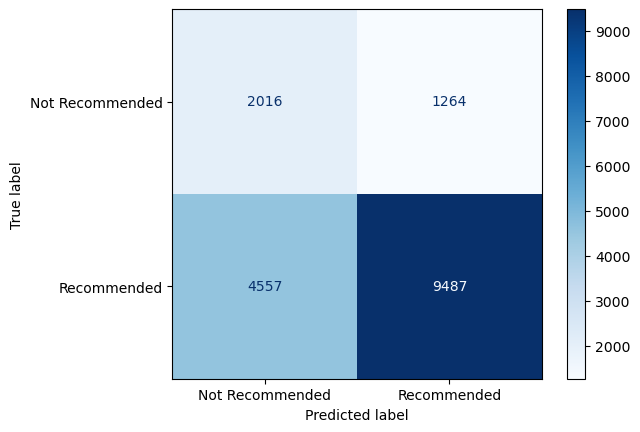

In [11]:
# Using test set to create a confusion matrix of the predictions

# Training the model on the entire training set
pipeline.fit(X_train_resampled, y_train_resampled)

# Predicting the test set results
y_pred = pipeline.predict(X_test)

# Making the Confusion Matrix
cm = confusion_matrix(y_test, y_pred)

disp = ConfusionMatrixDisplay(
    confusion_matrix=cm, display_labels=["Not Recommended", "Recommended"]
)
disp.plot(cmap=plt.cm.Blues)
plt.show()